In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset # Network Common Data Form
import sys
import xarray as xr
from datetime import date
from matplotlib import cm
from metpy.plots import ContourPlot, ImagePlot, MapPanel, PanelContainer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [8]:
# Import Data in this cell

dri  = '/lss/research/agon-lab/CAM_hindcasts/tratl_cam5.3_ne30_rneale.globe/'
fn5  = 'tratl_cam5.3_ne30_rneale.globe.fcast.day05.PRECT.nc'
fn10 = 'tratl_cam5.3_ne30_rneale.globe.fcast.day10.PRECT.nc'
fn15 = 'tratl_cam5.3_ne30_rneale.globe.fcast.day15.PRECT.nc'
fn20 = 'tratl_cam5.3_ne30_rneale.globe.fcast.day20.PRECT.nc'

driObs = '/lss/research/agon-lab/TMPA-daily/'
fnObs  = 'pr_daily_2009-2010.nc'

#data5 = xr.open_dataset(dri+fn5)
data5  = xr.open_dataset(dri+fn5, decode_times=False)
data10 = xr.open_dataset(dri+fn10,decode_times=False)
data15 = xr.open_dataset(dri+fn15,decode_times=False)
data20 = xr.open_dataset(dri+fn20,decode_times=False)

dataObs = xr.open_dataset(driObs+fnObs,decode_times=False)

# Align obs time stamps with hindcast time stamps: 'days since 2009-09-01 00:00:00'
timeObs = dataObs['time'] - 40055

<xarray.DataArray 'time' (time: 152)>
array([ 35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,
        59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,
        71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,
        83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106.,
       107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117., 118.,
       119., 120., 121., 122., 123., 124., 125., 126., 127., 128., 129., 130.,
       131., 132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165., 166.,
       167., 168., 169., 170., 171., 172., 173., 174., 175., 176., 177., 178.,
       179., 180., 181., 182., 183., 184., 185., 186.])
Coordinates:
  * time     (time) float64 35.0 36.0 37.0 38.0 39.0 ... 183.0 184.0 185.0 186.0
Attributes:
    bounds:     time_bnds
    calendar:   noleap
    units:      days since 2009-09-01 00:00:00
    long_name:  time

In [3]:
# ************************************************************************************************
# *************************** USER INPUTS ARE REQUIRED IN THIS CELL ******************************
# ************************************************************************************************


#### Select the date to be analyzed as a value representing the number of days since 2009-09-01 ####
dayOfTheSeason = 183 # For reference: 174 is February 22 and 122 is January 1
#dayOfTheSeason = 'cftime.DatetimeNoLeap(2010-03-02 00:00:00)'

#### Select the number of days to be time averaged ####
numDayAvg = 2

#### Select which day hindcast should be used ####
#DayXXHcast = [5,10,15,20]  # Must be a list of integer(s) from >=1 and <=20

# Choose region of interest 
lats = -20
latn =  20
lonw = -180 # *** For longitudes west of the Prime Meridian, enter a negative number ***
lone = -90  

# ************************************************************************************************

In [4]:
# Prepare the raw data so it is ready to be plotted

# Select the precip data
# Subtract 1 from numDayAvg to proper stop point of slice. Add 360 to lon to match coordinates of raw data.
precip5  =  data5['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
precip10 = data10['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
precip15 = data15['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))
precip20 = data20['PRECT'].sel(time=slice(dayOfTheSeason, dayOfTheSeason+numDayAvg-1), lat=slice(lats,latn), lon=slice(lonw+360,lone+360))

precipObs = dataObs['pr'].sel(time=slice(dayOfTheSeason+40055, dayOfTheSeason+numDayAvg-1+40055), lat=slice(lats,latn), lon=slice(lonw,lone))

# Average the selected precip data and change units from m/s to mm/day
precip_avg5  =  precip5.mean(axis=0)*1000*86400 
precip_avg10 = precip10.mean(axis=0)*1000*86400 
precip_avg15 = precip15.mean(axis=0)*1000*86400 
precip_avg20 = precip20.mean(axis=0)*1000*86400 

precip_avgObs = precipObs.mean(axis=0)

# Group together precip data for plotting purposes
precip_avg = [0,0,0,0]
precip_avg[0] = precip_avg5
precip_avg[1] = precip_avg10
precip_avg[2] = precip_avg15
precip_avg[3] = precip_avg20

/opt/miniconda3/envs/prod/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/opt/miniconda3/envs/prod/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


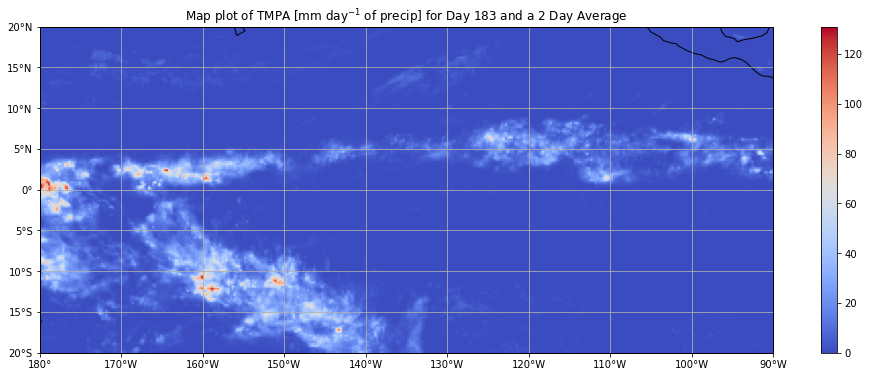

In [5]:
# Create a map plot of the observation data

# Create the figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 6)) 

geo_axes = plt.axes(projection=ccrs.PlateCarree())
geo_axes.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
geo_axes.set_yticks(np.arange(lats,latn+1,5), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
geo_axes.xaxis.set_major_formatter(lon_formatter)
geo_axes.yaxis.set_major_formatter(lat_formatter)
geo_axes.coastlines()
geo_axes.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
image_extent = [lonw,lone,lats,latn]

#a1 = geo_axes.contourf(lon, lat, precip_avg, N, transform=ccrs.PlateCarree(), extend='both',cmap='coolwarm')
IM = geo_axes.imshow(precip_avgObs, extent=image_extent, cmap='coolwarm')

plt.colorbar(IM, ax=geo_axes, orientation='vertical', pad=0.05)
plt.title("Map plot of TMPA [mm day$^{-1}$ of precip] for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average")
plt.show()

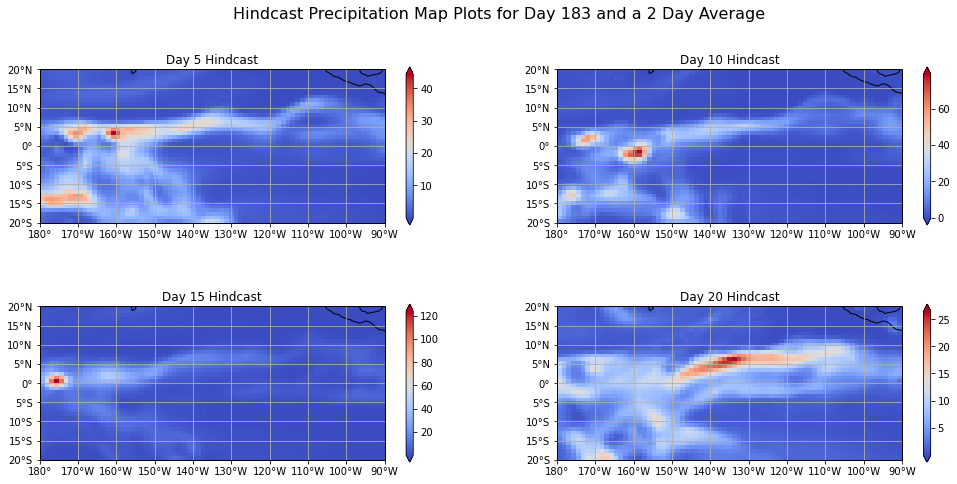

In [44]:
# Plot four subplots for each hindcast day

# Determine the maximum precip value for use in the colorbar
Vmax = max([precip_avg5.max(),precip_avg10.max(),precip_avg15.max(),precip_avg20.max()])
vmin = 0

# Set border of image
image_extent = [lonw,lone,lats,latn]

# Create figure and apply asthetic constraints
fig = plt.figure(figsize=(17, 8))

ax1 = plt.subplot(2, 2, 1, projection=ccrs.PlateCarree())
IM1 = ax1.imshow(precip_avg5, extent=image_extent, cmap='coolwarm')
plt.colorbar(IM1, ax=ax1, orientation='vertical', pad=0.05, shrink=0.8, extend='both')

ax1.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.coastlines()
ax1.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
ax1.title.set_text('Day 5 Hindcast')

ax2 = plt.subplot(2,2,2,projection=ccrs.PlateCarree())
IM2 = ax2.imshow(precip_avg10, extent=image_extent, cmap='coolwarm')
plt.colorbar(IM2, ax=ax2, orientation='vertical', pad=0.05, shrink=0.8, extend='both')

ax2.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
ax2.set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.coastlines()
ax2.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
ax2.title.set_text('Day 10 Hindcast')

ax3 = plt.subplot(2,2,3,projection=ccrs.PlateCarree())
IM3 = ax3.imshow(precip_avg15, extent=image_extent, cmap='coolwarm')
plt.colorbar(IM3, ax=ax3, orientation='vertical', pad=0.05, shrink=0.8, extend='both')

ax3.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
ax3.set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax3.xaxis.set_major_formatter(lon_formatter)
ax3.yaxis.set_major_formatter(lat_formatter)
ax3.coastlines()
ax3.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
ax3.title.set_text('Day 15 Hindcast')

ax4 = plt.subplot(2,2,4,projection=ccrs.PlateCarree())
IM4 = ax4.imshow(precip_avg20, extent=image_extent, cmap='coolwarm')
plt.colorbar(IM4, ax=ax4, orientation='vertical', pad=0.05, shrink=0.8, extend='both')

ax4.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
ax4.set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax4.xaxis.set_major_formatter(lon_formatter)
ax4.yaxis.set_major_formatter(lat_formatter)
ax4.coastlines()
ax4.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5))
ax4.title.set_text('Day 20 Hindcast')

fig.suptitle("Hindcast Precipitation Map Plots for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average",size=16,y=0.95)

plt.show()


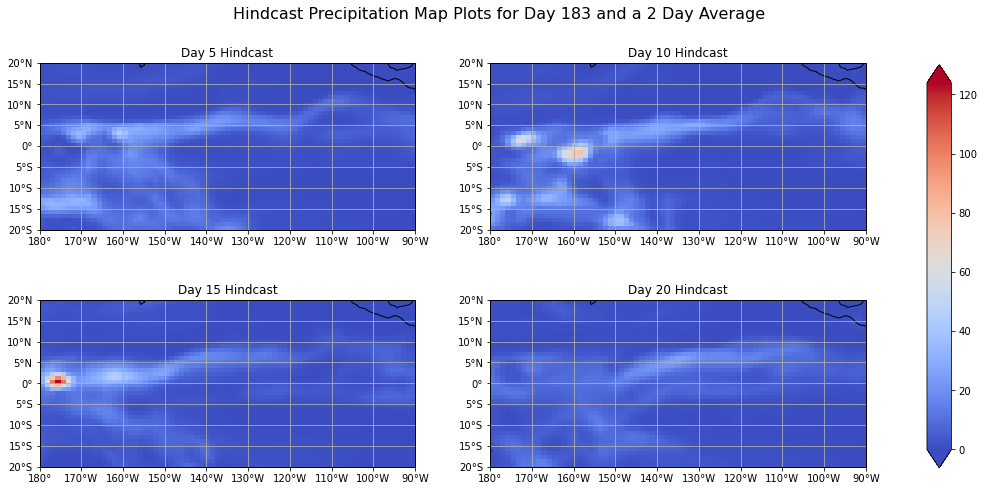

In [43]:
# Determine the maximum precip value for the colorbar
Vmax = max([precip_avg5.max(),precip_avg10.max(),precip_avg15.max(),precip_avg20.max()])

# Set border of image
image_extent = [lonw,lone,lats,latn]

# Pre-generate the subplots with a PlateCarree projection
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(17, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

#Iterate through the subplots
counter = 0
for ax in axes.flat:
    # Plot precip
    im = ax.imshow(precip_avg[counter], extent=image_extent, cmap='coolwarm', vmin=0, vmax=Vmax)
    
    # Set asthetic constraints of the plot
    ax.set_xticks(np.arange(lonw,lone+1,10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lats,latn+1,5),  crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.coastlines()
    ax.gridlines(xlocs=np.arange(lonw,lone+1,10), ylocs=np.arange(lats,latn+1,5)) 
    ax.title.set_text('Day '+str((counter+1)*5)+' Hindcast')
        
    counter = counter + 1
    
# This sections creates a new axes for the colorbar
fig.subplots_adjust(right=0.8)
# Add base axis for color bar. Located at 85% from left and 15% from bottom. Width is 2% of figure. Height is 70% of figure.
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, extend='both')

fig.suptitle("Hindcast Precipitation Map Plots for Day "+str(dayOfTheSeason)+" and a "+str(numDayAvg)+" Day Average",size=16,y=0.95)
plt.show()